In [31]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc

In [32]:
import json
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
data = []
with open('train.jsonl', 'r') as file:
    for line in file:
        entry = json.loads(line)
        data.append(entry)

In [34]:
image_paths = [entry['img'] for entry in data]
texts = [entry['text'] for entry in data]
labels = [entry['label'] for entry in data]

In [35]:
#  Load images and preprocess them
image_data = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    # Perform image preprocessing here (resize, normalize, etc.)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0  # Normalize pixel values
    image_data.append(img)

In [36]:
image_data = np.array(image_data)
labels = np.array(labels)

In [37]:
# Tokenize and pad text data
max_words = 1000  # Max number of words to tokenize
maxlen = 100  # Max sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
text_data = pad_sequences(sequences, maxlen=maxlen)

In [38]:
X_train_img, X_val_img, X_train_text, X_val_text, y_train, y_val = train_test_split(
    image_data, text_data, labels, test_size=0.2, random_state=42
)

In [39]:
image_model = Sequential()
image_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Conv2D(64, (3, 3), activation='relu'))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Conv2D(128, (3, 3), activation='relu'))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Conv2D(128, (3, 3), activation='relu'))
image_model.add(MaxPooling2D((2, 2)))
image_model.add(Flatten())

In [40]:
text_model = Sequential()
text_model.add(Embedding(max_words, 32, input_length=maxlen))
text_model.add(LSTM(64))

In [41]:
merged = concatenate([image_model.output, text_model.output])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(merged)

In [42]:
combined_model = Sequential()
combined_model = tf.keras.models.Model(inputs=[image_model.input, text_model.input], outputs=output)

In [43]:
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
combined_model.fit([X_train_img, X_train_text], y_train, epochs=10, batch_size=32, validation_data=([X_val_img, X_val_text], y_val))

Epoch 1/10
213/213 [==============================] - 62s 287ms/step - loss: 0.6443 - accuracy: 0.6482 - val_loss: 0.5831 - val_accuracy: 0.7200
Epoch 2/10
213/213 [==============================] - 66s 310ms/step - loss: 0.5555 - accuracy: 0.7240 - val_loss: 0.5430 - val_accuracy: 0.7371
Epoch 3/10
213/213 [==============================] - 72s 336ms/step - loss: 0.5181 - accuracy: 0.7534 - val_loss: 0.5550 - val_accuracy: 0.7306
Epoch 4/10
213/213 [==============================] - 64s 301ms/step - loss: 0.5004 - accuracy: 0.7644 - val_loss: 0.5506 - val_accuracy: 0.7247
Epoch 5/10
213/213 [==============================] - 63s 298ms/step - loss: 0.4834 - accuracy: 0.7726 - val_loss: 0.5799 - val_accuracy: 0.7065
Epoch 6/10
213/213 [==============================] - 64s 303ms/step - loss: 0.4683 - accuracy: 0.7853 - val_loss: 0.5897 - val_accuracy: 0.7159
Epoch 7/10
213/213 [==============================] - 71s 335ms/step - loss: 0.4537 - accuracy: 0.7878 - val_loss: 0.6061 - val_ac

In [44]:
loss, accuracy = combined_model.evaluate([X_val_img, X_val_text], y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

54/54 [==============================] - 5s 84ms/step - loss: 0.6410 - accuracy: 0.7182
Validation Accuracy: 71.82%


In [45]:
combined_model.save('combined_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
model = load_model('combined_model.h5')

In [47]:
pred_y = model.predict([X_val_img, X_val_text])

54/54 [==============================] - 4s 73ms/step


In [48]:
predicted_labels = (pred_y > 0.5).astype(int)

In [49]:
conf_matrix = confusion_matrix(y_val, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[924 178]
 [301 297]]


In [50]:

# Classification Report
print("Classification Report:")
print(classification_report(y_val, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1102
           1       0.63      0.50      0.55       598

    accuracy                           0.72      1700
   macro avg       0.69      0.67      0.67      1700
weighted avg       0.71      0.72      0.71      1700



In [51]:
import matplotlib.pyplot as plt

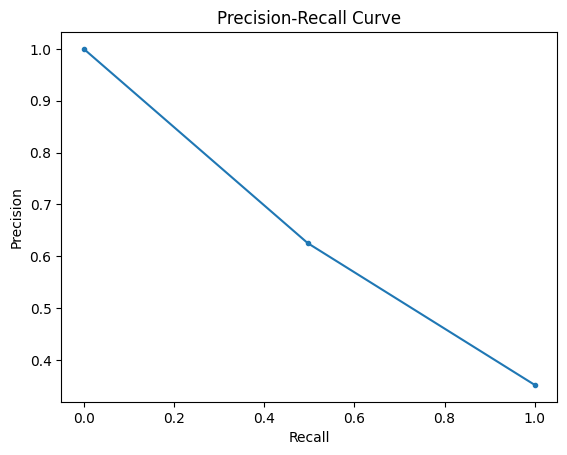

In [52]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, predicted_labels)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Text(0.5, 0, 'False Positive Rate')

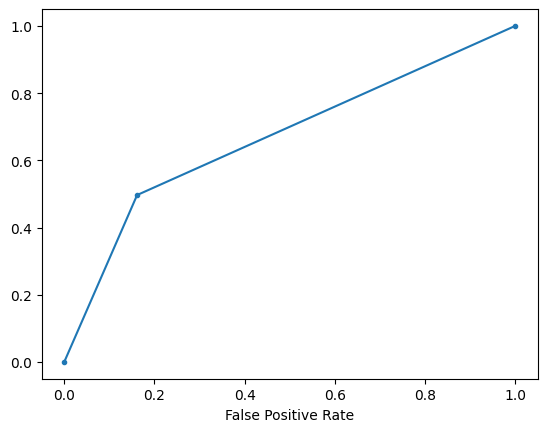

In [53]:

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, predicted_labels)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')

In [54]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_val, predicted_labels)

print(f"AUC: {auc:.4f}")

AUC: 0.6676


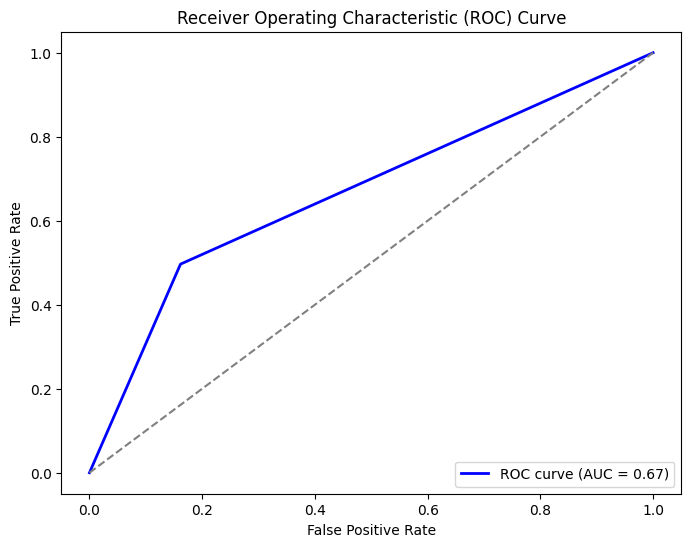

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, predicted_labels)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line indicating random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [56]:
from sklearn.manifold import TSNE

In [57]:
image_features = image_model.predict(image_data)
text_features = text_model.predict(text_data)

266/266 [==============================] - 2s 5ms/step


In [62]:
combined_features = np.concatenate((image_features, text_features), axis=1)
# Create labels for distinguishing image and text features
labels = np.array([0]*len(image_features) + [1]*len(text_features))

In [63]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(combined_features)

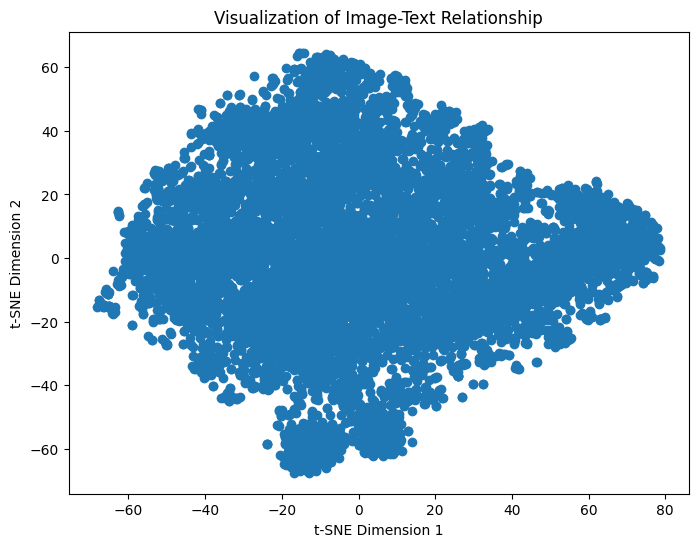

In [68]:
# Plotting the embedded features
plt.figure(figsize=(8, 6))
plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
plt.title('Visualization of Image-Text Relationship')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()